In [88]:
import os
import glob
import numpy as np
import pandas as pd

from pathlib import Path
from PIL import Image
from sklearn.metrics import confusion_matrix
from skimage.morphology import closing, remove_small_objects

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
### Replace with path to data downloaded from GCP
data_dir = '/Users/aidandaly/NYGC Dropbox/Aidan Daly/cell_segmentation_colon'

In [3]:
FG_CLASSES = {51: 'Muscle', 102:'Epithelial', 153:'Immune', 
	204:'Colonocyte', 255:'Interstitial'}

In [4]:
pred_dirs_adult = {
	'Colonocyte': os.path.join(data_dir, 'test_pred_colonocyte_20211129'),
	'Muscle': os.path.join(data_dir, 'test_pred_muscle_20211203'),
	'Epithelium': os.path.join(data_dir, 'test_pred_epithelium_20211208'),
	'Noncolonocyte': os.path.join(data_dir, 'test_pred_noncolonocyte_20211214'),
	'Peyers Patch': os.path.join(data_dir, 'test_pred_peyerspatch_20211210')
}
test_labels_adult = os.path.join(data_dir, 'testset_groundtruth_adult')

pred_dirs_young = {
	'Colonocyte': os.path.join(data_dir, 'test_preds_young_20220513/colonocyte'),
	'Muscle': os.path.join(data_dir, 'test_preds_young_20220513/muscle'),
	'Epithelium': os.path.join(data_dir, 'test_preds_young_20220513/epithelium'),
	'Noncolonocyte': os.path.join(data_dir, 'test_preds_young_20220513/noncolonocyte'),
	'Peyers Patch': os.path.join(data_dir, 'test_preds_young_20220513/peyers_patch')
}
test_labels_young = os.path.join(data_dir, 'testset_groundtruth_young')

In [5]:
def preprocess_label_img(lbl_img):
	'''
	Parameters:
	----------
	lbl_img: ndarray
		integer array where each pixel value corresponds to its assigned class.

	Returns:
	----------
	cleaned: ndarray
		integer array with gaps, edge artifacts, and small objects removed.

	'''
	cleaned = closing(lbl_img)	# Fills in holes in foreground (nonzero pixels)

	# For each foreground class, remove small objects (<50px)
	for c in np.unique(cleaned):
		if c > 0:
			cells_in = (cleaned == c)
			cleaned[cells_in] = 0
			cells_in = remove_small_objects(cells_in, min_size=50)
			cleaned[cells_in] = c
	return cleaned

In [109]:
def plot_confusion_matrix(true_dir, pred_dirs):
    mat_all = None
    
    fig, ax = plt.subplots(1, 10, figsize=(24,4), width_ratios=[8,1]*5, constrained_layout=True)

    tot_correct, tot = 0,0
    
    for i, clf in enumerate(['Colonocyte', 'Muscle', 'Epithelium', 'Noncolonocyte', 'Peyers Patch']):
        true_lbls_fg = []
        pred_lbls_fg = []
        sdir = pred_dirs[clf]
    
        for pred_fh in glob.glob(os.path.join(sdir, '*Object Predictions.tiff')):
            true_fh = os.path.join(true_dir, Path(pred_fh).name)
            if os.path.exists(true_fh) and os.path.exists(pred_fh):
                true_lbls = np.array(Image.open(true_fh).convert('L'))
                pred_lbls = np.array(Image.open(pred_fh).convert('L'))
    
                if np.sum(true_lbls > 0) != np.sum(pred_lbls > 0): 
                    print('WARNING: %s %s different FG (skipping)' % (true_fh, pred_fh))
                    continue
    
                # Preprocessing (remove small objects, etc.)
                true_lbls = preprocess_label_img(true_lbls)
                pred_lbls = preprocess_label_img(pred_lbls)
    
                # Only perform comparison over objects labeled as FG in both images
                # (preprocessing may affect images differently; cells can be split or joined)
                fg_inds = np.logical_and(true_lbls>0, pred_lbls>0)
                true_lbls_fg.append(true_lbls[fg_inds])
                pred_lbls_fg.append(pred_lbls[fg_inds])
    
        true_lbls_fg = np.concatenate(true_lbls_fg)
        pred_lbls_fg = np.concatenate(pred_lbls_fg)
    
        tot_correct += np.sum(true_lbls_fg == pred_lbls_fg)
        tot += len(true_lbls_fg)
    
        label_vals = [51, 102, 153, 204, 255]
        ticklabels = [FG_CLASSES[x] for x in label_vals]
        
        cmat_raw = confusion_matrix(true_lbls_fg, pred_lbls_fg, 
            labels=label_vals, normalize=None)
        cmat_norm = confusion_matrix(true_lbls_fg, pred_lbls_fg, 
            labels=label_vals, normalize='true')

        # Scientific formatting for colorbar
        formatter = tkr.ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((0, 1))

        sns.heatmap(cmat_raw, ax=ax[2*i],
                    annot=cmat_norm, fmt='.0%', annot_kws={'size':14},
                    xticklabels=ticklabels, yticklabels=ticklabels if i==0 else False,
                    cbar=True, cbar_ax=ax[2*i+1],cbar_kws={'label':'pixels', 'format':formatter},
                    cmap='RdPu'
                   )
        # Hide 0.00 annotations
        for text, cmn in zip(ax[2*i].texts, cmat_norm.ravel()):
            text.set_visible(cmn>=0.009)
            #if cmn > 0.009:
            #    print(cmn, text.get_text())

        ax[2*i].set_xticklabels(ax[2*i].get_xticklabels(), rotation=30, fontsize=15)
        ax[2*i].set_yticklabels(ax[2*i].get_yticklabels(), fontsize=15)
        
        ax[2*i].set_aspect('equal')
        ax[2*i].set_title(clf, fontsize=16)
        ax[2*i].set_xlabel('Label (Predicted)', fontsize=16)

    ax[0].set_ylabel('Label (True)', fontsize=16)
    
    print(tot_correct, tot, tot_correct/tot)

2974798 3312653 0.8980107484846738
2632913 3295896 0.7988458980501812


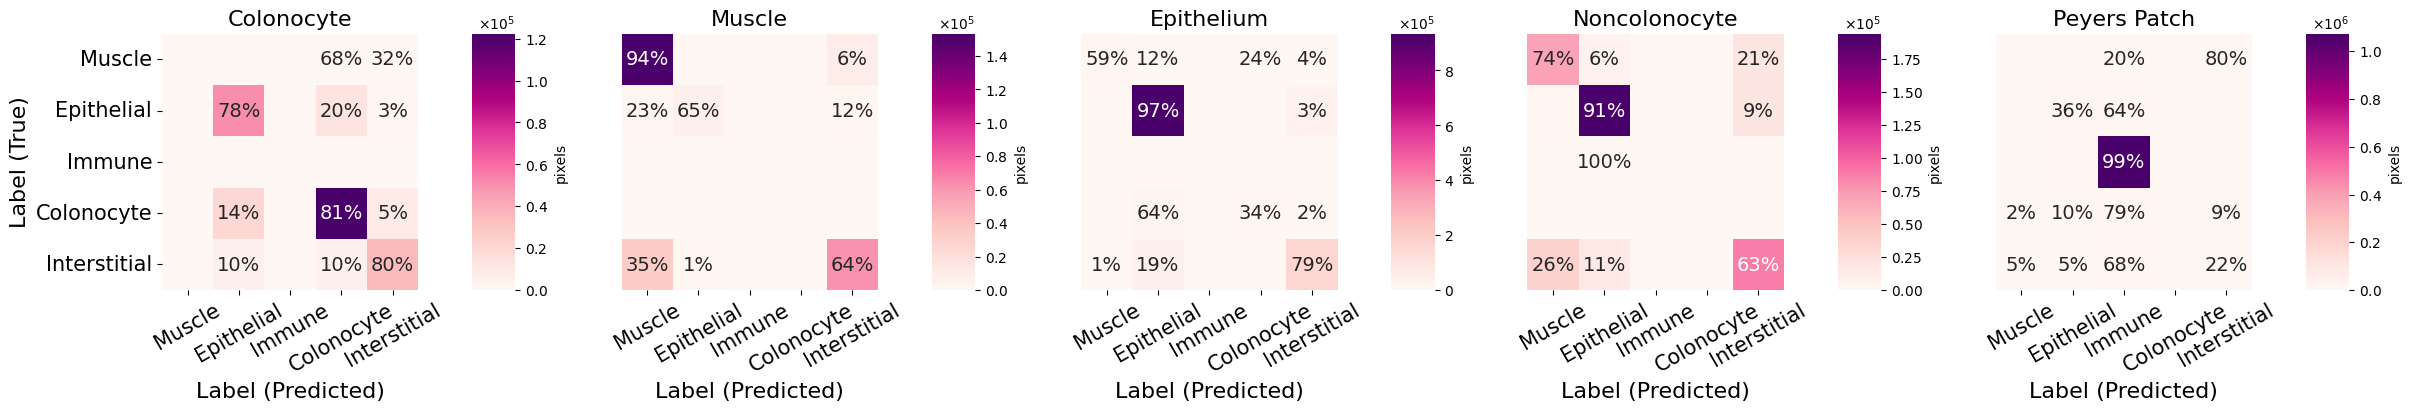

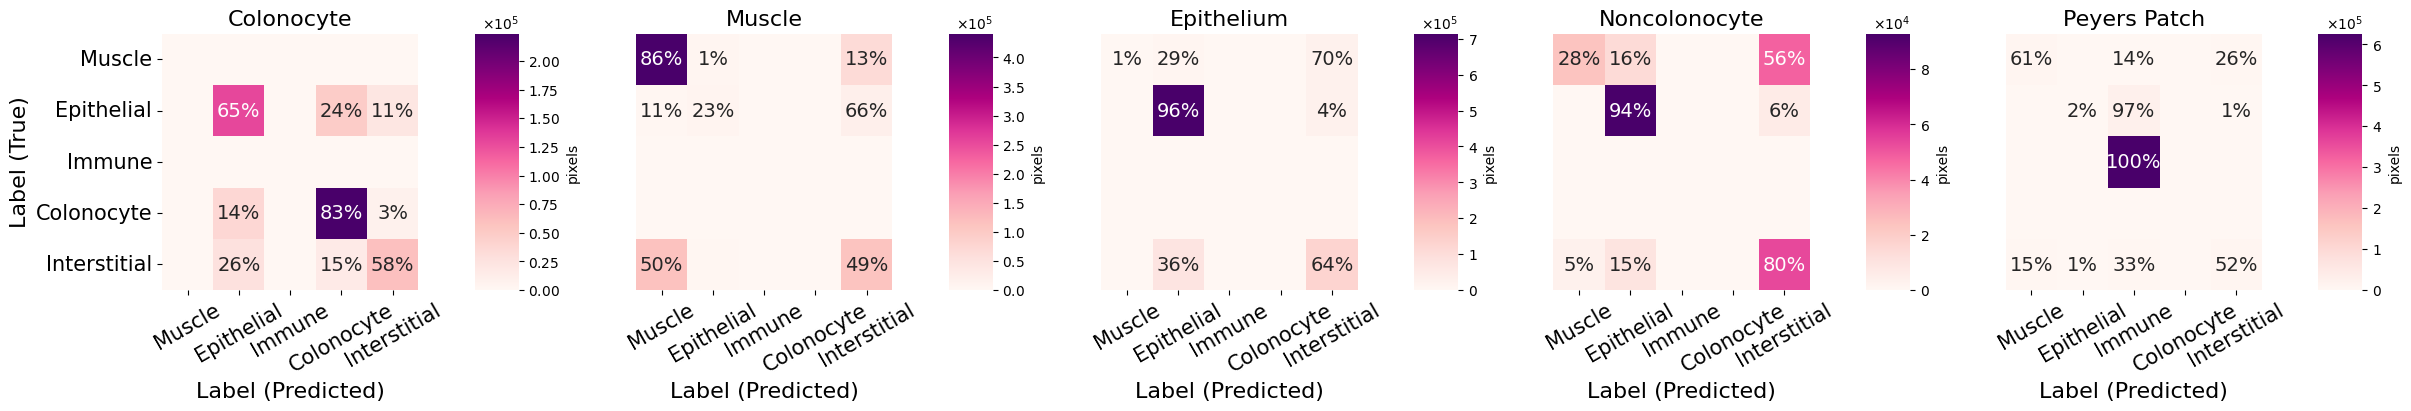

In [110]:
plot_confusion_matrix(test_labels_adult, pred_dirs_adult)
plt.savefig('confusion_adult_heatmap.svg')

plot_confusion_matrix(test_labels_young, pred_dirs_young)
plt.savefig('confusion_young_heatmap.svg')

In [23]:
(2974798+2632913)/(3312653+3295896)

0.8485540471894814